In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import pickle

from os import listdir, walk
from os.path import isfile, join
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense, Input
from keras.models import load_model
from keras import optimizers 
from keras import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [3]:
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = {0:'Sitting',
          1:'Sleeping',
          2:'Standing',
          3:'Walking'}
# The number of steps within one time segment
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 30

keras version  2.2.4


In [4]:
def read_data(file_path):

    column_names = ['id',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis',
                    'activity']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [5]:
df = read_data('Full3001-3006.csv')

In [6]:
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 10998



,id,timestamp,x-axis,y-axis,z-axis,activity
1,3001,03:24.7,0.24475623,0.566140753,0.521934,2
2,3001,03:24.9,0.259021138,0.555542186,0.523260,2
3,3001,03:25.0,0.259771939,0.570797704,0.526133,2
4,3001,03:25.2,0.253014846,0.572885305,0.520829,2
5,3001,03:25.4,0.255830292,0.562286727,0.518177,2
6,3001,03:25.5,0.248697838,0.572564136,0.527901,2
7,3001,03:25.7,0.256581093,0.568870695,0.519945,2
8,3001,03:25.8,0.255267211,0.574812314,0.519945,2
9,3001,03:26.0,0.253577967,0.575133493,0.518177,2
10,3001,03:26.2,0.253953328,0.570315958,0.524807,2


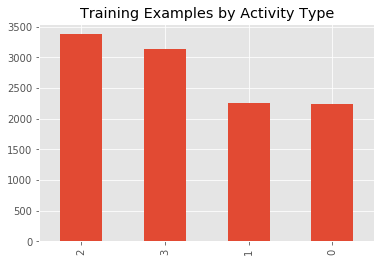

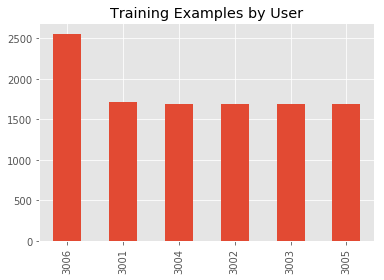

In [7]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

TypeError: unsupported operand type(s) for -: 'float' and 'str'

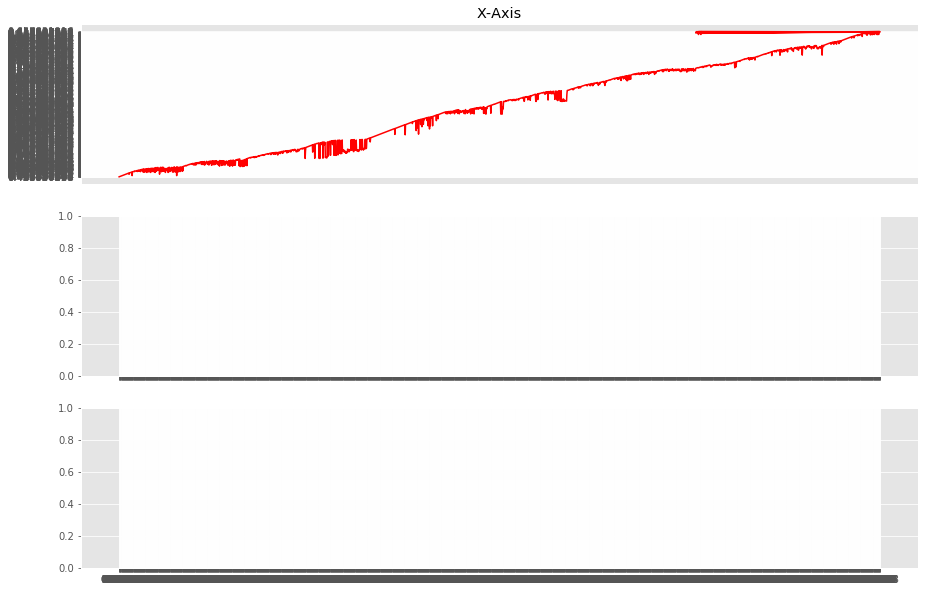

In [8]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity]
    plot_activity(activity, subset)

In [9]:
LABEL = 'activity'
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [10]:
df

,id,timestamp,x-axis,y-axis,z-axis,activity
1,3001,03:24.7,0.24475623,0.566140753,0.521934,2
2,3001,03:24.9,0.259021138,0.555542186,0.523260,2
3,3001,03:25.0,0.259771939,0.570797704,0.526133,2
4,3001,03:25.2,0.253014846,0.572885305,0.520829,2
5,3001,03:25.4,0.255830292,0.562286727,0.518177,2
6,3001,03:25.5,0.248697838,0.572564136,0.527901,2
7,3001,03:25.7,0.256581093,0.568870695,0.519945,2
8,3001,03:25.8,0.255267211,0.574812314,0.519945,2
9,3001,03:26.0,0.253577967,0.575133493,0.518177,2
10,3001,03:26.2,0.253953328,0.570315958,0.524807,2


In [11]:
df_test = df[df['id'] > '3004']
df_train = df[df['id'] <= '3004']

In [15]:
df_train.shape

(6761, 6)

In [17]:
df_test.shape

(4237, 6)

In [12]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [13]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (224, 60, 3)
224 training samples
y_train shape:  (224,)


In [20]:
n_timesteps, n_features = x_train.shape[1], x_train.shape[2]
n_outputs = le.classes_.size
print(list(le.classes_))

['0', '1', '2', '3']


In [21]:
input_shape = (n_timesteps*n_features)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (224, 180)
input_shape: 180


In [22]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [23]:
y_train_hot = np_utils.to_categorical(y_train, n_outputs)
print('New y_train shape: ', y_train_hot.shape)


New y_train shape:  (224, 4)


In [24]:
def build_lstm_model(n_timesteps, n_features, n_outputs):
    
  
  ######## TODO 3 ########
    inp = Input((n_timesteps, n_features))
    x = LSTM(units=64, activation='relu', return_sequences=True)(inp)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    outp = Dense(n_outputs, activation='softmax')(x)
    model = Model(inp, outp)
    return model

In [25]:
model = build_lstm_model(n_timesteps, n_features, n_outputs)

Instructions for updating:
Colocations handled automatically by placer.


UnboundLocalError: local variable 'a' referenced before assignment

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.001)

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 32
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=[early_stopping,reduce_lr],
                      validation_split=0.2,verbose=1)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [ ]:
all_subjects = []
for i in range(3001,3007):
    all_subjects.append(str(i))
    
for i in range(4001,4005):
    all_subjects.append(str(i))

In [ ]:
all_subjects

In [ ]:
len(all_subjects)

In [ ]:
all_subj = []
for i in range(10):
    all = load_timer(all_subjects[i])
    all_subj.append(all)

In [ ]:
%run load_dataset.ipynb

In [ ]:
subj_range = np.hstack(np.arange(3001,3007))

all_patients = [str(i) for i in subj_range]

In [ ]:
subj_range = np.hstack(np.arange(4001,4005))
all_test = [str(i) for i in subj_range]

In [ ]:
X_all_p, y_all_p, subj_all_p, ts_all_p, hr_all_p = load_all_data(all_patients)

In [ ]:
%run preprocessing.ipynb

In [ ]:
X_all_p

In [ ]:
X_all_p.shape

In [ ]:
y_all_p

In [ ]:
y_all_p.shape

In [ ]:
print(label_list)
print(label_dict)

In [ ]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange','darkviolet','gold','pink']

In [ ]:
all_subjects = all_patients

In [ ]:
X_label, y_label = label_grouping(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)
plot_all_label(X_label, y_all_p, new_label_list, new_label_dict)

In [ ]:
X_all_p.shape

In [ ]:
x_pure, y_pure = prepare_pure_label(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)
y_pure = y_pure.reshape((y_pure.shape[0],))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pure, y_pure, test_size=0.2, random_state=42)

In [ ]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

In [ ]:
x = np.reshape(x_train(x_train[0], x_train[1],3))

In [ ]:
x_pure.shape

In [ ]:
x_train[0]

In [ ]:
y_train.shape

In [ ]:
model = Sequential()
model.add

In [ ]:
input = Input(shape = (8606,180))
x = LSTM(100, activation ='tanh',return_sequences = True)(input)
#x = Dropout(0.2)(x)
x = LSTM(100, activation = 'tanh', return_sequences = False)(x)
#x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation = 'softmax')(x)
model = Model(inputs = input, outputs = x)
model.summary()

In [ ]:
model = Sequential()
model.add(LSTM(input_dim=n_timesteps, output_dim=n_features, activation='tanh', return_sequences=False))  # Dropout overfitting

#     # model.add(GRU(layers[2],activation='tanh', return_sequences=True))
#     # model.add(Dropout(0.2))  # Dropout overfitting

model.add(LSTM(100, activation='tanh', return_sequences=False))

model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))


#     #start = time.time()
#     # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#     # model.compile(loss="mse", optimizer=sgd)
#     #model.compile(loss="mse", optimizer="rmsprop") # Nadam rmsprop
#     #print "Compilation Time : ", time.time() - start

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [ ]:
h = model.fit(x_train, y_train, nb_epoch=50, batch_size = 64,
    validation_data=(x_test, y_test),shuffle=True, callbacks = [early_stopping,reduce_lr])